In [1]:
import os 
import statistics


from keras import backend, Model
from keras.layers import Activation, Dense, Dropout, Input, LeakyReLU
from keras.utils.generic_utils import get_custom_objects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow_docs import plots as tfplots

In [3]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)


def load(filename):
    return pd.read_csv(os.path.join(data_folder, filename)).rename(columns={'Unnamed: 0': 'ID'}).set_index('ID')

In [2]:
os.chdir(os.getcwd())
data_folder = 'dataset/'

## Import Data

In [4]:
X_train, Y_train = load('X_train.csv'), load('Y_train.csv')
X_test = load('X_test.csv')

In [5]:
X_train.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt
ID,,,,,,,,,
0,40.71239,-73.95271,4,2,0.19,1,0,1,0
1,40696.00000,-73.91303,4,17,0.66,2,307,1,0
2,40.62707,-74.02817,3,1,0.04,1,87,0,0
3,40.77910,-73.98565,1,4,0.08,1,0,0,1
4,40.75777,-73.93509,1,0,0.00,1,358,1,0


In [6]:
Y_train.head()

,price
ID,
0,65
1,57
2,225
3,175
4,125


In [7]:
X_test.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt
ID,,,,,,,,,
0,40.68579,-73.97455,2,4,0.17,1,0,0,1
1,40.67085,-73.92316,1,9,0.61,1,0,1,0
2,40.68817,-73.91523,2,31,1.35,5,0,1,0
3,40.67201,-73.86944,3,0,0.00,2,363,1,0
4,40.68696,-73.92905,1,7,0.19,1,0,1,0


## Data Analysis & Preprocessing

In [8]:
X = pd.merge(X_train, Y_train, left_index=True, right_index=True)

In [ ]:
sns.pairplot(X, vars=['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365'])

![Seaborn scatterplot](images/scatterplot.png "Seaborn scatterplot")

### Price

In [10]:
X['price'].describe()

count    33884.000000
mean       153.605389
std        249.102710
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Count'>

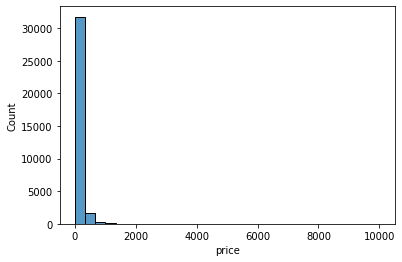

In [11]:
sns.histplot(X['price'], bins=30)

In [12]:
price_upper_bound = (X['price'].mean() + X['price'].std())*1.5

X = X[X['price'] <= price_upper_bound]
X['price'].describe()

count    33330.000000
mean       134.020252
std         94.025246
min          0.000000
25%         69.000000
50%        104.000000
75%        175.000000
max        600.000000
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Count'>

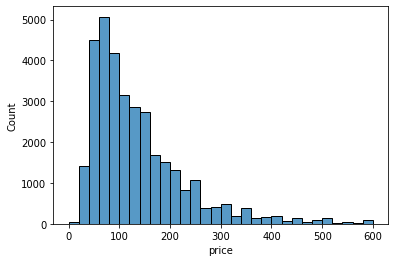

In [13]:
sns.histplot(X['price'], bins=30)

### Minimum Number of Nights

In [14]:
X['minimum_nights'].describe()

count    33330.000000
mean         7.052625
std         20.060310
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1000.000000
Name: minimum_nights, dtype: float64

<AxesSubplot:xlabel='minimum_nights', ylabel='Count'>

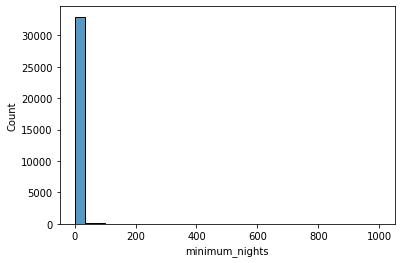

In [15]:
sns.histplot(X['minimum_nights'], bins=30)

In [16]:
nights_upper_bound = (X['minimum_nights'].mean() + X['minimum_nights'].std())*1.5

X['minimum_nights'] = X['minimum_nights'].clip(upper=int(nights_upper_bound))
X['minimum_nights'].describe()

count    33330.000000
mean         6.081548
std          9.045165
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max         40.000000
Name: minimum_nights, dtype: float64

<AxesSubplot:xlabel='minimum_nights', ylabel='Count'>

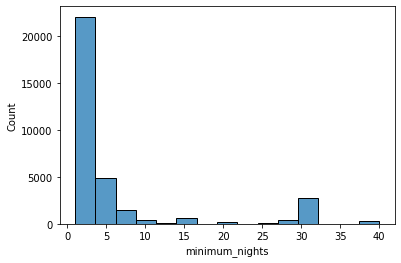

In [17]:
sns.histplot(X['minimum_nights'], bins=15)

In [18]:
X_train, Y_train = X[X.columns[:-1]], pd.DataFrame(X[X.columns[-1]])

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33330 entries, 0 to 33883
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        33330 non-null  float64
 1   longitude                       33330 non-null  float64
 2   minimum_nights                  33330 non-null  int64  
 3   number_of_reviews               33330 non-null  int64  
 4   reviews_per_month               33330 non-null  float64
 5   calculated_host_listings_count  33330 non-null  int64  
 6   availability_365                33330 non-null  int64  
 7   Private_room                    33330 non-null  int64  
 8   Entire_home/apt                 33330 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 2.5 MB


In [19]:
Y_train.describe()

,price
count,33330.000000
mean,134.020252
std,94.025246
min,0.000000
25%,69.000000
50%,104.000000
75%,175.000000
max,600.000000


In [20]:
columns = ['latitude', 'longitude', 'number_of_reviews']

X_train.drop(columns=columns, inplace=True)
X_test.drop(columns=columns, inplace=True)

In [21]:
print('Train dimensions:', X_train.shape)

Train dimensions: (33330, 6)


## Neural Network

In [22]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

In [23]:
def compile_network(X, activation, output_size):
    inputs = Input(shape=(X.shape[1]), name='Input')
    x = Dense(64, activation=activation)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(8, activation=activation)(x)
    x = Dense(output_size)(x)

    model = Model(inputs, x)
    model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [24]:
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

def swish(x, beta = 1):
    return (x * tf.keras.activations.sigmoid(beta * x))

get_custom_objects().update({'gelu': Activation(gelu)})
get_custom_objects().update({'swish': Activation(swish)})
get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})


In [25]:
histories = {}
activations = ['relu', 'gelu', 'elu', 'selu', 'leaky-relu', 'swish']

for activation in activations:
    print('[{}] Training started...'.format(activation))
    model = compile_network(X_train, activation, Y_train.shape[1])

    histories[activation] = model.fit(X_train, Y_train,
        batch_size=32,
        epochs=20,
        verbose=2,
        validation_data=(X_validation, Y_validation))
    print('')

    backend.clear_session()
    del model

[relu] Training started...
Epoch 1/20
834/834 - 1s - loss: 14025.6318 - root_mean_squared_error: 118.4299 - val_loss: 9578.8506 - val_root_mean_squared_error: 97.8716
Epoch 2/20
834/834 - 0s - loss: 8172.6475 - root_mean_squared_error: 90.4027 - val_loss: 6398.3296 - val_root_mean_squared_error: 79.9896
Epoch 3/20
834/834 - 0s - loss: 6835.2666 - root_mean_squared_error: 82.6757 - val_loss: 6063.0278 - val_root_mean_squared_error: 77.8654
Epoch 4/20
834/834 - 0s - loss: 6583.0117 - root_mean_squared_error: 81.1358 - val_loss: 5984.8677 - val_root_mean_squared_error: 77.3619
Epoch 5/20
834/834 - 0s - loss: 6471.7041 - root_mean_squared_error: 80.4469 - val_loss: 6104.8013 - val_root_mean_squared_error: 78.1332
Epoch 6/20
834/834 - 0s - loss: 6452.7598 - root_mean_squared_error: 80.3291 - val_loss: 5923.2900 - val_root_mean_squared_error: 76.9629
Epoch 7/20
834/834 - 0s - loss: 6348.2905 - root_mean_squared_error: 79.6762 - val_loss: 6000.6182 - val_root_mean_squared_error: 77.4637
Epoch

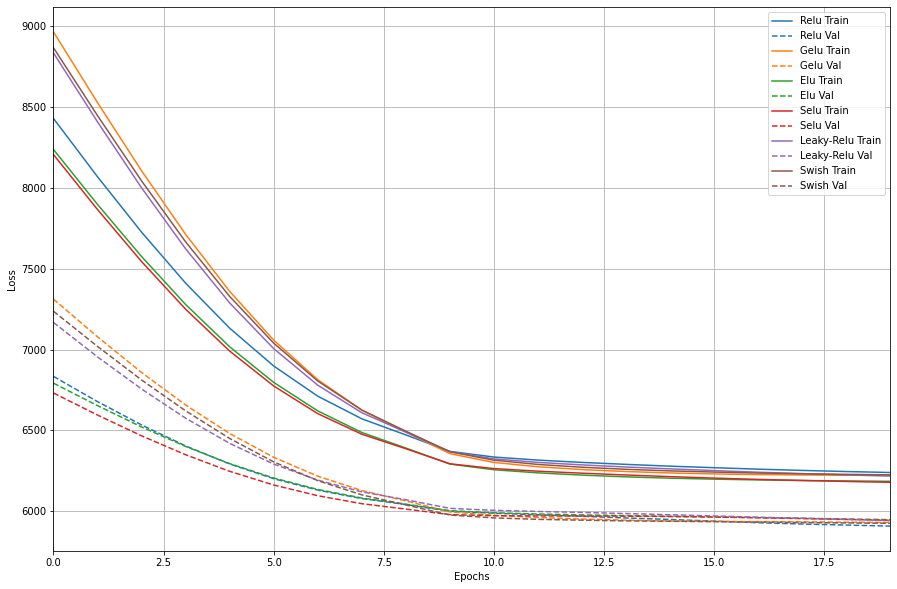

In [38]:
plotter = tfplots.HistoryPlotter(metric='loss', smoothing_std=2)

plt.figure(figsize=(15, 10))
plotter.plot(histories)

## Prediction

In [30]:
activation = 'relu'

model = compile_network(X_train, activation, Y_train.shape[1])
history = model.fit(X_train, Y_train,
    batch_size=32,
    epochs=20,
    verbose=2,
    validation_data=(X_validation, Y_validation))

Epoch 1/20
834/834 - 1s - loss: 14262.0391 - root_mean_squared_error: 119.4238 - val_loss: 10027.3115 - val_root_mean_squared_error: 100.1365
Epoch 2/20
834/834 - 0s - loss: 8355.8623 - root_mean_squared_error: 91.4104 - val_loss: 6536.0713 - val_root_mean_squared_error: 80.8460
Epoch 3/20
834/834 - 0s - loss: 6864.3931 - root_mean_squared_error: 82.8516 - val_loss: 6147.9028 - val_root_mean_squared_error: 78.4086
Epoch 4/20
834/834 - 0s - loss: 6646.7163 - root_mean_squared_error: 81.5274 - val_loss: 6088.2651 - val_root_mean_squared_error: 78.0273
Epoch 5/20
834/834 - 0s - loss: 6522.8896 - root_mean_squared_error: 80.7644 - val_loss: 6287.3970 - val_root_mean_squared_error: 79.2931
Epoch 6/20
834/834 - 0s - loss: 6421.4819 - root_mean_squared_error: 80.1341 - val_loss: 6072.5723 - val_root_mean_squared_error: 77.9267
Epoch 7/20
834/834 - 0s - loss: 6386.5776 - root_mean_squared_error: 79.9161 - val_loss: 6001.9204 - val_root_mean_squared_error: 77.4721
Epoch 8/20
834/834 - 0s - loss

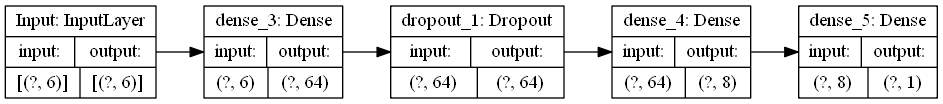

In [39]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

In [31]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 6)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                448       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________


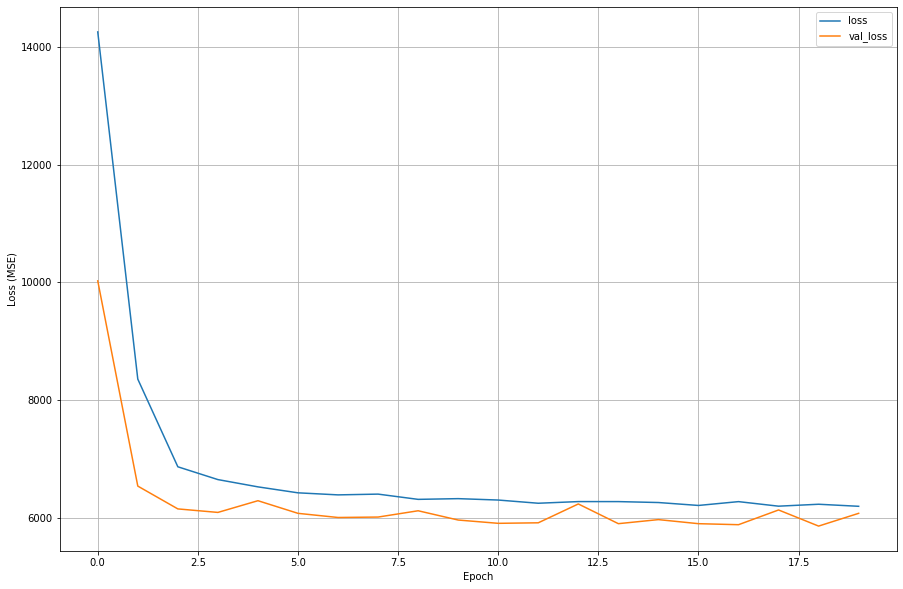

In [37]:
plt.figure(figsize=(15, 10))
plot_loss(history)

# Prediction

In [40]:
Y_test = model.predict(X_test)
np.savetxt('results/Y_test.txt', Y_test, newline='\n')
print(Y_test)

[[167.4917  ]
 [ 74.70512 ]
 [ 68.45848 ]
 ...
 [167.76793 ]
 [169.9898  ]
 [ 69.903206]]
